<img src="media/Cryo+ESA_Logo_plain-50gray.svg" alt="CCI Cryosphere banner" width="1000"/>

# Exercise: Greenland mass change from satellite gravimetry

The Gravity Recovery and Climate Experiment (GRACE, and it's follow-on GRACE-FO), [have the unique ability to 'weigh' the ice sheets from space](https://earth.esa.int/eogateway/missions/grace). The satellite mission uses the principle that satellite orbits are affected by gravitational changes of the Earth. In reversal, a very accurate tracking of the satellite orbits over time allows the determination of mass changes on the Earth.

In this exercise we download and visualize a GRACE CCI product of ice mass change using cate. After the exercise you'll have an idea of the current imbalance of the Greenland icesheet and see where the icesheet is losing mass.

## Preparations
If you haven't done so please follow the [Cate tutorial](https://www.futurelearn.com/courses/understanding-climate-change-using-satellite-climate-data/1/steps/1230976) to get started using the Jupyter notebook exercises.

## Cate software and the open data portal

We'll be querying the open data portal for sea ice concentration products as produced by the [Climate Change Initiative Sea Ice project](https://climate.esa.int/en/projects/sea-ice/). The [**open data portal**](https://climate.esa.int/en/odp/#/dashboard) hosts a variety of datasets on the [Jasmin infrastructure on the UK](https://jasmin.ac.uk/). These can be queried using the dedicated [Cate python module](https://cate.readthedocs.io/en/latest/). Cate allows retrieving data from the data portal and the web-interface which you find at [cate.climate.esa.int](https://cate.climate.esa.int) is build upon it.

In this Jupyter notebook exercise we will directly call Cate functions, and it will show you how these can be used in advanced workflows.

## Starting the exercise
To perform the exercise and execute the code in this notebook you can run it through the [mybinder.org](https://mybinder.org/) service by clicking on the binder link below (if resources allow it). Alternatively, you can download/clone the notebooks from [github](https://github.com/CCI-Tools/cate-edu) and run them through your own Jupyter notebook instance (this may initially take more time to setup, but does allow you to store your changes and extend the notebooks exercises to your own needs).

[![click to run this notebook on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CCI-Tools/cate-edu/HEAD?filepath=ECVs%2F09_IcesheetsGreenland-exercise.ipynb)

or [clone the notebook repository on github](https://github.com/CCI-Tools/cate-edu)

## Step 1: loading python modules and initialize the data store pool

In [1]:
# To get things started we need to initialize a few things
#Load some python modules to make them accessible to the notebook
from cate.core.ds import DATA_STORE_POOL
import cate.ops as ops
from cate.util.monitor import ConsoleMonitor
from cate.core.ds import get_metadata_from_descriptor
from cate.ops.io import open_dataset

# the following is needed to run Cate in a Jupyter Notebook
from xcube.util.ipython import enable_asyncio
enable_asyncio()

# utilities
from IPython.display import display
import numpy as np
from datetime import datetime

monitor = ConsoleMonitor()

To begin, let us see which data stores are available in the Data Store Pool.

In [2]:
DATA_STORE_POOL.store_instance_ids

['cci-store', 'cci-zarr-store', 'local']

We see three different stores. 

The **cci-store** is a store that provides access to all datasets from the CCI Open Data Portal. It connects to the Open Data Portal and allows access to the datasets listed at https://catalogue.ceda.ac.uk. We can ask for the search parameters of the store to see how a search can be performed.

The **cci-zarr-store** is a store that contains selected data from the Open Data Portal, converted to the [zarr format](https://zarr.readthedocs.io/en/stable/). The datasets from this store can be opened and processed faster, but the store provides only a small subset of what is offered by the **cci-store**. 

The **local** data store finally allows to access locally provided data. Also, when you select to cache data, you will find it in this store. Cached data can also be opened quickly.

This notebook will allow you to try out both the *cci-zarr-store* and the *cci-store*. Just uncomment/comment the appropriate `cci_store` variable below.

In [3]:
# uncomment/comment the cci_store variable below to use the 
# cci_store = 'cci-zarr-store'
cci_store = 'cci-store'

data_store = DATA_STORE_POOL.get_store(cci_store)
display(data_store.get_search_params_schema())

if cci_store == 'cci-zarr-store':
    #you can also list all the data ids of the smaller zarr catalogue
    list(data_store.get_data_ids())

## Step 2: Finding ice sheet mass change data
For this exercise, we are interested in GRACE data sets, so we ask for datasets of the platform "GRACE". We then display the results of the query.

In [4]:
# lets query the dataserver
icesheetqry = data_store.search_data(platform="GRACE")

for i,item in enumerate(icesheetqry):
    print(f'\nDataset item {i}:')
    display(item)

/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/xcube_cci/cciodp.py:1184: CciOdpWarning: Variable "crs" has no fill value, cannot set one. For parts where no data isavailable you will see random values. Thisis usually the case when data is missing for a time step.
  warnings.warn(f'Variable "{fixed_key}" has no fill value, '



Dataset item 0:



Dataset item 1:



Dataset item 2:



Dataset item 3:



Dataset item 4:



Dataset item 5:



Dataset item 6:



Dataset item 7:


Of these, we pick "esacci.ICESHEETS.yr.Unspecified.GMB.GRACE-instrument.GRACE.UNSPECIFIED.1-5.greenland_gmb_mass_trends" and open it. The parameter 'data_store_id' is not absolutely necessary, but it makes the opening a little faster.

In [5]:
yr = 2012
trange = [datetime(yr,1,1), datetime(yr,12,31)]
#note the appropriate dataset is called slightly different depending on the cci-store which is being used
if cci_store == 'cci-store':
    dataset_id = "esacci.ICESHEETS.yr.Unspecified.GMB.GRACE-instrument.GRACE.UNSPECIFIED.1-5.greenland_gmb_mass_trends"
elif cci_store == "cci-zarr-store":
    dataset_id = "ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr"

#describe the dataset
data_descriptor = data_store.describe_data(dataset_id)
display(data_descriptor)    
   


In [6]:
greenTrnd = open_dataset(ds_id=dataset_id, data_store_id=cci_store)

/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/xcube_cci/dataaccess.py:286: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(chunk_store)
/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/dask/array/core.py:397: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


## Step 3: Create a geographical plot of the mass trends

In [7]:
greenTrnd

<xarray.Dataset>
Dimensions:     (time: 15, meas_ind: 901, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 2002-07-02T12:00:00 ... 2016-07-02
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(15, 2), meta=np.ndarray>
Dimensions without coordinates: meas_ind, bnds
Data variables:
    GMB_trend   (time, meas_ind) float32 dask.array<chunksize=(15, 901), meta=np.ndarray>
    end_time    (time) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
    latitude    (time, meas_ind) float32 dask.array<chunksize=(1, 901), meta=np.ndarray>
    longitude   (time, meas_ind) float32 dask.array<chunksize=(1, 901), meta=np.ndarray>
    start_time  (time) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
    t           (time) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     esacci.ICESHEETS.yr.Unspecified.GMB.GRACE-inst...
    date_created:              2021-11-04T15:08:52.700363
    processing_level:          Unspecified
    time_coverage_start:       2002-01-01T00:00:00
    time_coverage_end:         2017-01-01T00:00:00
    time_coverage_duration:    P5480D
    history:                   [{'program': 'xcube_cci.chunkstore.CciChunkSto...
    time_coverage_resolution:  P365D

Text(0.5, 1.0, 'mm/yr (equivalent water) 2002 - 2002')

/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/alicja/miniconda3/envs

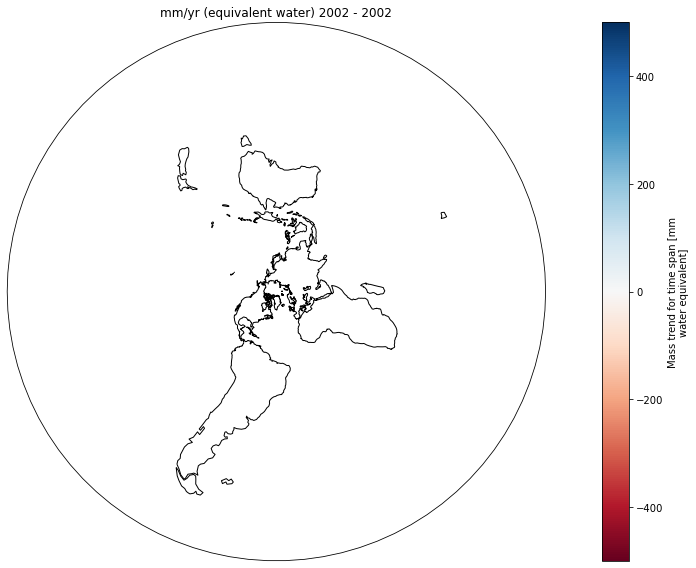

In [20]:
from xarray.plot import scatter
import cartopy.crs as ccrs
import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np

%matplotlib inline
itime = 0
yrstart = np.datetime_as_string(greenTrnd.start_time[itime].time.values, unit="Y")
yrend = np.datetime_as_string(greenTrnd.end_time[itime].time.values, unit="Y")

mpl.figure(figsize=(16, 8))
crs = ccrs.NorthPolarStereo(-45)
xy = crs.transform_points(ccrs.PlateCarree(), greenTrnd.longitude.values, greenTrnd.latitude.values)
ax = mpl.subplot(projection=crs)
ax.coastlines()
greenTrnd.isel(time=itime).plot.scatter(x="longitude", 
                                        y="latitude", 
                                        hue="GMB_trend", 
                                        cmap="RdBu",
                                        transform=ccrs.PlateCarree(),
                                        ax=ax,
                                        vmin=-500,
                                        vmax=500,
                                        s=70,
                                        marker='H')
ax.set_title(f"mm/yr (equivalent water) {yrstart} - {yrend}")

## Questions (please share and discuss your answers on the forum)
* Try to select different trend periods (variable `itime`). In which regions do you see changes?
* To better visualize the areas which have undergone change, adapt (or copy) the code and plot the difference between two trend periods.
* The spatial resolution of mass changes from GRACE and GRACE-FO are much coarser than what can be obtained from for example ice altimetry from e.g. Cryosat-2, but there are advantages too. Try to make a list of advantages/disadvantages of gravimetry versus altimetry and exchange your findings on the forum.
